In [11]:
import sys
import os

sys.path.append(os.path.abspath('D:\ITC\РНФ_Курганский_2024\pythonProject'))

import numpy as np
import torch
from torch import nn
import math

from scipy.spatial import Delaunay
import matplotlib.pyplot as plt

import spin_system, utils, particles, res_field_algorithm, constants, spectral_integration, mesher, spectra_manager, particles
from visualization import levels_plot, transitions_plot
from population import time_population, tr_utils, transform
import population

from importlib import reload

from spectra_manager import TruncatedSpectraCreatorTimeResolved, PostSpectraProcessing,TimeResolvedIntensitiesCalculator, ParamSpec
from spectral_integration import SpectraIntegratorEasySpinLikeTimeResolved, BaseSpectraIntegrator


reload(population)
reload(time_population)
reload(levels_plot)
reload(transitions_plot)
reload(tr_utils)
reload(spectra_manager)

<module 'spectra_manager' from 'D:\\ITC\\РНФ_Курганский_2024\\pythonProject\\spectra_manager.py'>

In [25]:
mesh = mesher.DelaunayMeshNeighbour(phi_limits = (0, np.pi),
                                    initial_grid_frequency=12,
                                    interpolate=False)
rotation_matrices = mesh.create_rotation_matrices()

def build_powder(rotation_matrices, *args) -> spin_system.MultiOrientedSample:
        params = args[0] if len(args) == 1 else args
        g_factor, g_strain, D, D_str, E_D_attitude, h_strain = params

        # g-tensor components
        g_tensor = torch.full((3,), g_factor)
        g_frame = torch.zeros(3)
        g_strain_tensor = torch.full((3,), g_strain)

        # Zero-field splitting calculations
        D_val = 2.0 * D * 1e6
        E_val = 2.0 * D * E_D_attitude * 1e6
        #E_val = -2.0 * E * 1e6
        Dz = 2/3 * D_val
        Dx = -1/3 * D_val - E_val
        Dy = -1/3 * D_val + E_val

        # Strain calculations
        E_str = D_str * E_D_attitude
        #E_str = E_str
        Dx_s = -1/3 * D_str - E_str
        Dy_s = -1/3 * D_str + E_str
        Dz_s = 2/3 * D_str
        strain_e_e = torch.tensor([Dx_s, Dy_s, Dz_s]) \
            * (constants.PLANCK / constants.BOHR) * 1e6

        J = 1.1
        J = 2 * J # Because 2 S1 S2
        J_hz = (J * 100) * 3 * 1e8
        
        components_dipole = torch.tensor([Dx, Dy, Dz]) + J_hz
        d_frame = torch.zeros(3)

        # System construction
        zeem = spin_system.Interaction(g_tensor, g_frame, g_strain_tensor)
        ee_int = spin_system.Interaction(components_dipole, d_frame, strain_e_e)

        e1 = particles.Electron(spin=0.5)
        e2 = particles.Electron(spin=0.5)
        system = spin_system.SpinSystem(
            electrons=[e1, e2],
            g_tensors=[zeem, zeem],
            electron_electron=[(0, 1, ee_int)]
        )

        # Homogeneity strain
        hum_str = 3 * h_strain * torch.ones(3)
        hum_str *= (constants.PLANCK / constants.BOHR) * 4e5
        return spin_system.MultiOrientedSample(system, hum_str, rotation_matrices)
    
    
best_params_cw = {'g_factor': 2.0064026806055115,
 'g_strain': 0.0057826633838925995,
 'D': 88.95762784927365,
 'D_str': 70.71112429094259,
 'E_D_attitude': 0.3327962487663032,
 'h_strain': 8.08377174375672}
best_values_cw = list(best_params_cw.values())


powder = build_powder(rotation_matrices, best_values_cw)

In [13]:
mesh = mesher.DelaunayMeshNeighbour(phi_limits = (0, np.pi),
                                    initial_grid_frequency=10,
                                    interpolate=False)
rotation_matrices = mesh.create_rotation_matrices()

def build_powder(rotation_matrices, *args) -> spin_system.MultiOrientedSample:
        params = args[0] if len(args) == 1 else args
        g_factor, h_strain = params

        g_tensor = torch.full((3,), g_factor)
        g_frame = torch.zeros(3)
        g_strain_tensor = torch.full((3,), 0.0)

        # System construction
        zeem = spin_system.Interaction(g_tensor, g_frame, g_strain_tensor)

        e1 = particles.Electron(spin=0.5)
        system = spin_system.SpinSystem(
            electrons=[e1],
            g_tensors=[zeem],
        )

        # Homogeneity strain
        hum_str = 3 * h_strain * torch.ones(3)
        hum_str *= (constants.PLANCK / constants.BOHR) * 4e5
        return spin_system.MultiOrientedSample(system, hum_str, rotation_matrices)
    
    
best_params_cw = {'g_factor': 2.002, 'h_strain': 8.08377174375672}
best_values_cw = list(best_params_cw.values())


powder = build_powder(rotation_matrices, best_values_cw)

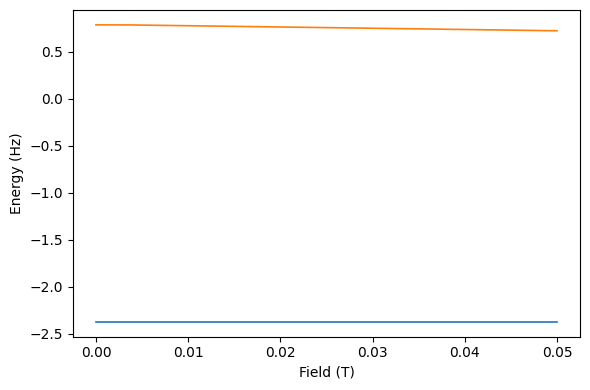

In [26]:
F, Gx, Gy, Gz = powder.get_hamiltonian_terms()
B = torch.linspace(0.0, 0.0500, 200)
B = B[..., None, None]
orient_hams = F[0] + B * Gz[0]
energies, vectors = torch.linalg.eigh(orient_hams)

import matplotlib.pyplot as plt
levels_plot.plot_energy_system(B, constants.unit_converter(energies), vectors, [0,1 ], False)

zero_ham = F
zero_energies, zero_vectors = torch.linalg.eigh(zero_ham)
config = {"zero_energies": zero_energies, "zero_vectors": zero_vectors}

In [27]:
reload(population)
reload(time_population)
reload(levels_plot)
reload(transitions_plot)
reload(tr_utils)
reload(spectra_manager)

<module 'spectra_manager' from 'D:\\ITC\\РНФ_Курганский_2024\\pythonProject\\spectra_manager.py'>

In [28]:
class CoupledSpectraCreatorDensity(spectra_manager.TruncatedSpectraCreatorTimeResolved):
    def __init__(self, spin_system_dim, batch_dims, mesh: mesher.BaseMesh, time: torch.Tensor,
                 intensity_calculator: TimeResolvedIntensitiesCalculator | None = None,
                 spectra_integrator: BaseSpectraIntegrator = SpectraIntegratorEasySpinLikeTimeResolved(harmonic=0),
                 post_spectra_processor: PostSpectraProcessing = PostSpectraProcessing(
                     torch.tensor(0), torch.tensor(0))):
        super().__init__(
            spin_system_dim, batch_dims, mesh, time, intensity_calculator, spectra_integrator, post_spectra_processor)

    def _get_output_eigenvector(self) -> bool:
        return True

    def _get_param_specs(self) -> list[ParamSpec]:
        params = [
            ParamSpec("vector", torch.float32),
            ParamSpec("vector", torch.complex64),
            ParamSpec("vector", torch.complex64),
            ParamSpec("matrix", torch.complex64),
            
            #ParamSpec("matrix", torch.complex64),
            #ParamSpec("matrix", torch.complex64),
            #ParamSpec("matrix", torch.complex64),
            #ParamSpec("matrix", torch.complex64)
            ]
        return params

    def _precompute_batch_data(self, sample: spin_system.MultiOrientedSample, F, Gx, Gy, Gz, batch):
        """
        :param sample:
        :param Gx:
        :param Gy:
        :param Gz:
        :param batch:
        :return:
        """
        intensity = self.intensity_calculator(Gx, Gy, Gz, batch)
        (vector_down, vector_up), (lvl_down, lvl_up),\
            B_trans, mask_trans, mask_triu, indexes, resonance_energies, vector_full = batch
        width_square = self.broader(sample, vector_down, vector_up, B_trans, indexes)

        freq_to_field_val = self._freq_to_field(vector_down, vector_up, Gz, indexes)
        #return mask_trans, mask_triu, B_trans, intensity, width_square, indexes, freq_to_field_val, resonance_energies,\
        #    vector_down, vector_up, vector_full, F, Gx, Gy, Gz
        return mask_trans, mask_triu, B_trans, intensity, width_square, indexes, freq_to_field_val, resonance_energies,\
            vector_down, vector_up, vector_full
     
    def _postcompute_batch_data(self, compute_out: tuple, fields: torch.Tensor,
                                F: torch.Tensor, Gx: torch.Tensor, Gy: torch.Tensor, Gz: torch.Tensor):
        mask_triu, res_fields, intensities, width, *extras = compute_out
        population = self.intensity_calculator.calculate_population_evolution(
            res_fields, mask_triu, *extras, F, Gx, Gy, Gz
        )
        #intensities = (intensities.unsqueeze(0) * population)
        intensities = population
        return (mask_triu, res_fields, intensities, width), fields
    
def build_config():
    k_x = 20.3723555477466  * 1.0 
    k_y = 145.4251328218196 * 1.0
    k_z = 8787.46130349088 * 1.0
    triplet_prob = 31.1356746538767
    
    free_probs = [[0.0, 0.0, 0.0, 0.0],
                  [0.0, 0.0, triplet_prob, 0.0],
                  [0.0, triplet_prob, 0.0, triplet_prob],
                  [0.0, 0.0, triplet_prob, 0.0]]
    
    free_probs = torch.tensor(free_probs)

    free_probs_tr =[
            [0, k_z, k_y, k_x],
            [k_z, 0, 0.0, 0.0],
            [k_y, 0.0, 0, 0.0],
            [k_x, 0.0, 0.0, 0]
        ]
    
    coherences = [
            [0, -1e6, -1e6, -1e6],
            [-1e6, 0, -1e6, -1e6],
            [-1e6, -1e6, 0, -1e6],
            [-1e6, -1e6, -1e6, 0]
        ]
    
    """
    k_z = 8787.46130349088 * 0.1
    free_probs = [[0.0, triplet_prob ],
                  [triplet_prob, 0.0]]
    
    free_probs = torch.tensor(free_probs)

    free_probs_tr =[
            [0, k_z],
            [k_z, 0],
        ]
    
    free_probs_tr = torch.tensor(free_probs_tr)
    coherences = [
            [0, -1e6],
            [-1e6, 0],
        ]

    """
    free_probs_tr = torch.tensor(free_probs_tr)
    coherences = 1e2 * torch.tensor(coherences)
    B1 = 1e-5
    w1 = constants.unit_converter(B1, "T_to_Hz_e")
    freq = 9.820899 * 1e9

    config = {"zero_energies": zero_energies,
              "zero_vectors": zero_vectors,
               "free_probs": free_probs,
               "free_probs_tr": free_probs_tr,
              "freq": freq,
              "B1": B1,
              "coherences": coherences
                 }
    return config

In [29]:
class Liouvilletor():
    def __init__(self):
        pass
    
    @staticmethod
    def commutator_super(operator: torch.Tensor):
        d = operator.shape[-1]
        I = torch.eye(d, dtype=operator.dtype, device=operator.device)
        
        batch_dims = operator.shape[:-2]
        
        term1 = torch.einsum('...ij,kl->...ikjl', operator, I).reshape(*batch_dims,d*d, d*d)
        term2 = torch.einsum('kl, ...ij->...kilj', I, operator.transpose(-1, -2)).reshape(*batch_dims, d*d, d*d)
        result = term1 - term2
        return -1j * result 
    
    @staticmethod
    def anticommutator_super(operator: torch.Tensor):
        d = operator.shape[-1]
        I = torch.eye(d, dtype=operator.dtype)
        term1 = torch.einsum('...ij,kl->...ikjl', operator, I)
        
        batch_dims = operator.shape[:-2]

        term1 = torch.einsum('...ij,kl->...ikjl', operator, I).reshape(*batch_dims, d*d, d*d)
        term2 = torch.einsum('kl,...ij->...kilj', I, operator.transpose(-1, -2)).reshape(*batch_dims, d*d, d*d)
        result = term1 + term2
        return result
    
    @staticmethod
    def decay_super(P: torch.Tensor, rate: float) -> torch.Tensor:
        """
        Returns the superoperator for non-Lindblad decay: -(rate/2)*{P, ⋅}
        """
        return -rate / 2 * Liouvilletor.anticommutator_super(P)
    
    @staticmethod
    def relaxation_superop(R: torch.Tensor, M: torch.Tensor) -> torch.Tensor:
        """
        R,M:  torch.ComplexTensor of shape [..., n, n]  (here n=3)
        returns
        L:   torch.ComplexTensor of shape [..., n*n, n*n],
             such that the population entries (= diag of rho)
               obey  dot(pop)=R@pop,
             and each coherence  rho_ij  (i!=j)
               obeys  dot(rho_ij)=M_ij * rho_ij.
        """
        *batch, n, _ = R.shape
        N = n*n
        
        idx = torch.arange(n, device=R.device) * (n + 1)
        mask_pop = torch.zeros((N, N), dtype=torch.bool, device=R.device)
        mask_pop[idx[:,None], idx[None,:]] = True
        mask_coh = ~mask_pop

        idx = torch.arange(n*n, device=R.device).reshape(n, n)
        pop_idx = idx.diagonal()
        A_pop = torch.zeros(*batch, n*n, n*n, device=R.device, dtype=R.dtype)
        A_pop[..., pop_idx[:, None], pop_idx[None, :]] = R

        M_flat = M.transpose(-2, -1).reshape(*batch, N)
        A_coh  = torch.diag_embed(M_flat)
        A_coh  = A_coh * mask_coh
        return A_pop + A_coh

In [30]:
import typing as tp

class EvolutionSuper():
    def __init__(self, H0,
                 H_freq: torch.Tensor | None = None,
                 transition_matrix: torch.Tensor | None = None,
                 coher_matrix: torch.Tensor | None = None,
                 context: dict[str, tp.Any] | None = None):
        self.context = context or {}
        if transition_matrix is None:
            coher_matrix = torch.zeros_like(H0)
        
        if coher_matrix is None:
            coher_matrix = torch.zeros_like(transition_matrix)
            
        self.R_T = Liouvilletor.relaxation_superop(transition_matrix, coher_matrix)
        self.L_H0 = Liouvilletor.commutator_super(H0)
        if H_freq is None:
            self.L_freq = torch.zeros_like(self.L_H0)
        else:
            self.L_freq = Liouvilletor.commutator_super(H_freq)

        
        self.omega = context["freq"] * 2 * math.pi
        
    def __call__(self, time: torch.Tensor):
        """
        :param time: time, where transition matrix should be found
        :return: tuple [temperature, base probabilities of transition,
        induced probabilities, outgoing probabilities]
        """
        t_flat = time.reshape(-1)
        L = self.R_T + self.L_H0
        time_cos = torch.cos(self.omega * time)[..., None, None, None, None]
        L_freq = time_cos * self.L_freq.unsqueeze(0)
        L = L_freq + L.unsqueeze(-5)
        return L

In [31]:
from torchdiffeq import odeint

class EvolutionMatrixSolver:
    @staticmethod
    def odeint_solver(time: torch.Tensor, initial_propagator: torch.Tensor,
                      matrix_generator: EvolutionSuper):
        def _rate_equation(t, U_pro: torch.Tensor, matrix_generator: EvolutionSuper):
            """
            RHS for dn/dt = M(t) @ U.
            - t: time
            - U: populations of shape (..., K, K)
            Returns U/dt of same shape.
            """
            M_t = matrix_generator(t)
            du_dt = torch.matmul(M_t, U_pro)
            return du_dt
        
        sol = odeint(func=lambda t, y: _rate_equation(
                     t, y, matrix_generator),
                     y0=initial_propagator,
                     t=time, atol=1e-12
                     )
        return sol

    @staticmethod
    def exponential_solver(time: torch.Tensor,
                          initial_propagator: torch.Tensor,
                          matrix_generator: EvolutionSuper):
        dt = (time[1] - time[0])
        M = matrix_generator(time)
        exp_M = torch.matrix_exp(M * dt)

        size = time.size()[0]
        n = torch.zeros((size, ) + initial_propagator.shape, dtype=initial_propagator.dtype)
        n[0] = initial_propagator
        
        for i in range(len(time)-1):
            current_n = n[i]  # Shape [..., K, K]
            next_n = torch.matmul(exp_M[i], current_n)
            n[i + 1] = next_n
        return n

    @staticmethod
    def stationary_rate_solver(time: torch.Tensor,
                         initial_propagator: torch.Tensor,
                         matrix_generator: EvolutionSuper):
        M = matrix_generator(time[0]).squeeze(dim=-5)

        dims_to_add = M.dim()

        reshape_dims = [len(time)] + [1] * dims_to_add
        time_reshaped = time.reshape(reshape_dims)

        exp_m = torch.matrix_exp(M * time_reshaped)
        n = torch.matmul(exp_m, initial_propagator)
        return n

In [35]:
import typing as tp
import qutip
import scipy

class AdvanceDensity(population.BaseTimeDependantPopulator):
    def __init__(self,
                 start_temp: float = 4.2,
                 context: dict[str, tp.Any] | None = None,):
        """
        :param start_temp: temperature in K
        """
        self.start_temp = torch.tensor(start_temp)
        self.context = context or None
        self.precision = "64"
        self.solver = EvolutionMatrixSolver.odeint_solver
        
    def _transofrm_to_eigenbasis(self, full_basis, args_vectors, args_matrix, **kwargs):
        out_vectors = []
        for vector in args_vectors:
            out_vectors.append(full_basis.conj().transpose(-1, -2) @ vector)
        
        out_matrix = []
        for matrix in args_matrix:
            out_matrix.append(full_basis.conj().transpose(-1, -2) @ matrix @ full_basis)
        return out_vectors, out_matrix
    
    def _vec(self, rho):
        shapes = rho.shape
        return rho.reshape(*shapes[:-2], shapes[-1] * shapes[-1])
    
    def _unvec(self, rho):
        shapes = rho.shape
        dim = int(math.sqrt(shapes[-1]))
        return rho.reshape(*shapes[:-1], dim, dim)
    
    def _get_initial_Hamiltonian(self, energies):
        return torch.diag_embed(energies) * math.pi * 2
        
    def _initial_density(self, energies, lvl_down, lvl_up, *args, **kwargs):
        populations = nn.functional.softmax(-constants.unit_converter(energies) / self.start_temp, dim=-1)
        density = torch.diag_embed(populations)
        
        if density.dtype == torch.float32:
            density = density.to(torch.complex64)
        elif density.dtype == torch.float64:
            density = density.to(torch.complex128)
        
        return density
    
    def propagator_2pi(self, config, evo, dtype, shape, n_steps=40):
        omega = config["freq"] * 2 * math.pi
        delta_phi = 2* math.pi / n_steps
        T = 2 * math.pi / omega
        times = torch.linspace(0, T, n_steps+1, dtype=torch.float64)
        d = shape[-1]**2
        initial_propagator = torch.eye(d, dtype=dtype).expand(*shape[:-2], d, d)
        
        U_times = self.solver(times, initial_propagator, evo)
        return U_times, times

    def U_N(self, U, power):
        return torch.matrix_power(U, power)
    
    def U_N_batched(self, U, powers):
        eiglev, eigbasis = torch.linalg.eig(U)
        embedings = torch.stack([torch.pow(eiglev, m) for m in powers], dim=-4)
        D = torch.diag_embed(embedings)
        
        return eigbasis @ D @ torch.linalg.inv(eigbasis)
        #return torch.stack([torch.matrix_power(U, m) for m in powers], dim=-5)
    
    def U_at(self, tau, U_list, ttensor):
        """Use property U(t) = U(phi1)*[U(2pi)]^N"""
        t_2pi = ttensor[-1]
        
        N = (tau / t_2pi).to(torch.int32)
        t1 = tau - N * t_2pi
        t1_idx = torch.searchsorted(ttensor, t1)

        if len(N) == 1:
            return self.U_N(U_list[-1], N)
        else:
            return self.U_N_batched(U_list[-1], N)

    def _get_resips(self, U_2pi, M_power):
        U_M = torch.linalg.matrix_power(U_2pi, M_power)            
        I = torch.eye(U_2pi.shape[-1], dtype=U_2pi.dtype, device=U_2pi.device)                                  
        resip_term_2pi = I - U_2pi
        resip_term_2pi_M = I - U_M
        return resip_term_2pi, resip_term_2pi_M
    
    def _get_integral_term(self, resip_term_2pi, resip_term_2pi_M, U_list, phi_interval):
        G = torch.linalg.solve(resip_term_2pi, resip_term_2pi_M)
        sum_part = U_list
        sum_term = torch.sum(
            sum_part[:-1] * torch.sin(phi_interval[:-1][:, None, None, None, None]), dim=-5)
        weighted_sum = sum_term
        return weighted_sum @ G
    
    
    def _compute_energy(
            self,
            config: dict,
            U_list: tp.List[torch.Tensor],
            tlist: torch.Tensor,
            rho_t: torch.Tensor,
            G: torch.Tensor,
        ) -> torch.Tensor:
            """Compute energy expectation value"""
            tau = 1 / config["freq"]
            w = config["freq"] * 2 * math.pi
            measurement_time = 80*1e-9
            M_power = int(measurement_time / tau)

            resip_term_2pi, resip_term_2pi_M = self._get_resips(U_list[-1], M_power)
            phi_interval = tlist * w
            delta_phi = phi_interval[1] - phi_interval[0]
            # Compute integral correction
            correction = (delta_phi / 12) * resip_term_2pi_M
            weighted_sum = self._get_integral_term(
                resip_term_2pi, 
                resip_term_2pi_M, 
                U_list, 
                phi_interval
            )
            #full_sum_term = weighted_sum + correction
            # Compute final expectation value
            integ_term = (delta_phi * (weighted_sum) @ rho_t / w).squeeze(dim=-1)
            
            
            integ_dm = self._unvec(integ_term)

            trace_term = G @ integ_dm
            trace_term = torch.diagonal(trace_term, dim1=-2, dim2=-1)
            
            a = -torch.diagonal(G @ integ_dm, dim1=-2, dim2=-1).sum(dim=-1).real
            print("-----------------------------")
            b = -torch.diagonal(G @ integ_dm, dim1=-2, dim2=-1).sum(dim=-1).imag
            return a
        
    def _post_compute(self, initial_populations, time_dep_population, lvl_down, lvl_up, *args, **kwargs):
        indexes = torch.arange(initial_populations.shape[-2], device=initial_populations.device)
        time_intensities = time_dep_population[..., indexes, lvl_down] - time_dep_population[..., indexes, lvl_up]
        #init_intensity = initial_populations[..., indexes, lvl_down] - initial_populations[..., indexes, lvl_up]
        return time_intensities
    
    def _precompute(self, res_fields, lvl_down, lvl_up, energies, vector_down, vector_up, config):
        energies = energies.clone()
        indexes = torch.arange(energies.shape[-2], device=energies.device)
        res_energies = energies[..., indexes, lvl_up] - energies[..., indexes, lvl_down]
        
        correction = (res_energies - config["freq"]) / 2
        
        D = energies.size(-2)              # 2
        batch_shape = energies.shape[:-2]  # e.g. [B1, B2, …]
        
        idx_up = (
            lvl_up               # shape [2]
            .view(*(1,)*len(batch_shape), D)    # → [1,1,…,2]
            .unsqueeze(-1)                      # → [1,1,…,2,1]
            .expand(*batch_shape, D, 1)         # → [*batch_dims, 2, 1]
        )

        src_up = -correction.unsqueeze(-1)    # → [*batch_dims, 2, 1]
        energies.scatter_add_(dim=-1, index=idx_up, src=src_up)
        
        idx_down = (
        lvl_down.view(*(1,)*len(batch_shape), D)
                     .unsqueeze(-1)
                     .expand(*batch_shape, D, 1)
        )
        src_down = correction.unsqueeze(-1)
        energies.scatter_add_(dim=-1, index=idx_down, src=src_down)
        
        res_energies = energies[..., indexes, lvl_up] - energies[..., indexes, lvl_down]
        correction = (res_energies - config["freq"]) / 2

        return res_fields, vector_down, vector_up, energies, lvl_down, lvl_up
        
    
    def _initial_populations(self, energies, lvl_down, lvl_up, *args, **kwargs):
        return nn.functional.softmax(-constants.unit_converter(energies) / self.start_temp, dim=-1)

    def get_omega(self, energies, lvl_down, lvl_up):
        indexes = torch.arange(energies.shape[-2], device=energies.device)
        return (energies[..., indexes, lvl_up] - energies[..., indexes, lvl_down]) * 2 * math.pi
    
    def __call__(self, res_fields, lvl_down, lvl_up, time, energies, vector_down, vector_up,
                 *args, **kwargs):
        res_fields, lvl_down, lvl_up, energies, vector_down, vector_up = self._precompute(
            res_fields, lvl_down, lvl_up,
            energies, vector_down, vector_up, config)
        
        full_basis = args[0]
        zero_energies = config["zero_energies"]
        zero_vectors =  config["zero_vectors"].unsqueeze(-3)
        F, Gx, Gy, Gz = (
            args[1].unsqueeze(-3),
            args[2].unsqueeze(-3),
            args[3].unsqueeze(-3),
            args[4].unsqueeze(-3)
            )
        
        coeffs = transform.get_transformation_coeffs(zero_vectors, full_basis)
        transformed_probs = transform.transform_rates_matrix(config["free_probs_tr"], coeffs)
        
        H0_lab = F + res_fields.unsqueeze(-1).unsqueeze(-1) * Gz
        (zero_vectors, ), (Gx, Gy, H0_lab) =\
            self._transofrm_to_eigenbasis(full_basis, (zero_vectors,), (Gx, Gy, H0_lab))
        # omegas = self.get_omega(energies, lvl_down, lvl_up)
        
        if self.precision == "64":
            zero_vectors = zero_vectors.to(torch.complex128)
            energies = energies.to(torch.float64)
            res_fields = res_fields.to(torch.float64)
            config["free_probs"] = config["free_probs"].to(torch.float64)
            Gx = Gx.to(torch.complex128)
            Gy = Gy.to(torch.complex128)
        else:
            pass
        
        H0 = self._get_initial_Hamiltonian(energies)
        evo_vector = tr_utils.EvolutionMatrix(energies)
        new_temp = 5.2
        transition_matrix = evo_vector(new_temp, transformed_probs + config["free_probs"])
        batch = transition_matrix.shape
        coherences = config["coherences"].expand(*batch)
        
        # FIND GX energy
        Ht = config["B1"] * Gx
        evo = EvolutionSuper(H0, Ht, transition_matrix, context=config, coher_matrix=coherences)
        
        dtype = Gx.dtype
        shape = H0.shape
        U_list, tlist = self.propagator_2pi(config, evo, dtype, shape, n_steps=200)
        U_N = self.U_at(time, U_list, tlist)
        #U_N = self.make_trace_preserving(U_N)
        
        rho_0 = self._vec(self._initial_density(energies, lvl_down, lvl_up))
        
        rho_t = U_N @ rho_0.unsqueeze(-1)
        rho_t[0] = rho_0.unsqueeze(-1)
        energy_x = self._compute_energy(config, U_list, tlist, rho_t, Gx)
        
        rho_t = self._unvec(rho_t.squeeze(dim=-1))
        populations_x = rho_t.diagonal(dim1=-1, dim2=-2).real
        
        omega = self.get_omega(energies, lvl_down, lvl_up)
        corr = omega - config["freq"] * 2 * math.pi

        # FIND Gy energy
        Ht = config["B1"] * Gy
        evo = EvolutionSuper(H0, Ht, transition_matrix, context=config, coher_matrix=coherences)

        dtype = Gx.dtype
        shape = H0.shape
        U_list, tlist = self.propagator_2pi(config, evo, dtype, shape, n_steps=200)
        U_N = self.U_at(time, U_list, tlist)
        #U_N = self.make_trace_preserving(U_N)
        
        rho_0 = self._vec(self._initial_density(energies, lvl_down, lvl_up))
        rho_t = U_N @ rho_0.unsqueeze(-1)   
        energy_y = self._compute_energy(config, U_list, tlist, rho_t, Gy)
        
        rho_t = self._unvec(rho_t.squeeze(dim=-1))
        populations_y = rho_t.diagonal(dim1=-1, dim2=-2).real
        
        pops = (populations_x + populations_y) / 2
        initial_populations = self._initial_populations(energies, lvl_down, lvl_up)
        #out = self._post_compute(initial_populations, pops, lvl_down, lvl_up)
        out = energy_x + energy_y
        #out = out
        return out

In [36]:
config = build_config()

advance_density = AdvanceDensity(4.2, config)

resonance_frequency = torch.tensor(config["freq"])
fields_t1 = torch.linspace(0.340, 0.360, 200)

size = 200

t_short = 1.52
t_long = 70.00

t_short_start = torch.tensor(0.15 * 1e-3)
t_long_start =  torch.tensor(6 * 1e-3)

time = torch.linspace(0.0, t_short, size, dtype=torch.float64) * 1e-3

intensity_calculator = spectra_manager.TimeResolvedIntensitiesCalculator(
    spin_system_dim=powder.spin_system.dim, populator=advance_density, time=time,
)

creator = CoupledSpectraCreatorDensity(
    powder.spin_system.dim,
    tuple(),
    mesh,
    time=time,
    intensity_calculator=intensity_calculator
)

In [37]:
with torch.no_grad():
    fields_t1 = torch.linspace(0.340, 0.360, 100)
    spec = creator(powder, resonance_frequency, fields_t1)

-----------------------------


IndexError: tensors used as indices must be long, int, byte or bool tensors

In [239]:
from matplotlib.colors import TwoSlopeNorm

def plot_heat_map(fields_t1: np.ndarray, time: np.ndarray, answer: np.ndarray):
    full_time = time[-1] 
    delta_field = fields_t1[1]- fields_t1[0]
    aspect = int(full_time / (2* delta_field)) + 10

    cmap = 'seismic'
    abs_max = abs(answer).max()
    norm = TwoSlopeNorm(
                vmin=-abs_max,
                vcenter=0.,
                vmax=abs_max,
    )
    
    
    
    fig = plt.figure(dpi=200)
    img = plt.imshow(
            answer,
            norm=norm,
            cmap=cmap,
            interpolation='bicubic',
            extent=[0, full_time, fields_t1[0], fields_t1[-1] ],
            aspect=aspect / 200,
            origin = "lower"
            )

    plt.colorbar(img, cmap=cmap)
    fig.set_size_inches(8, 6)

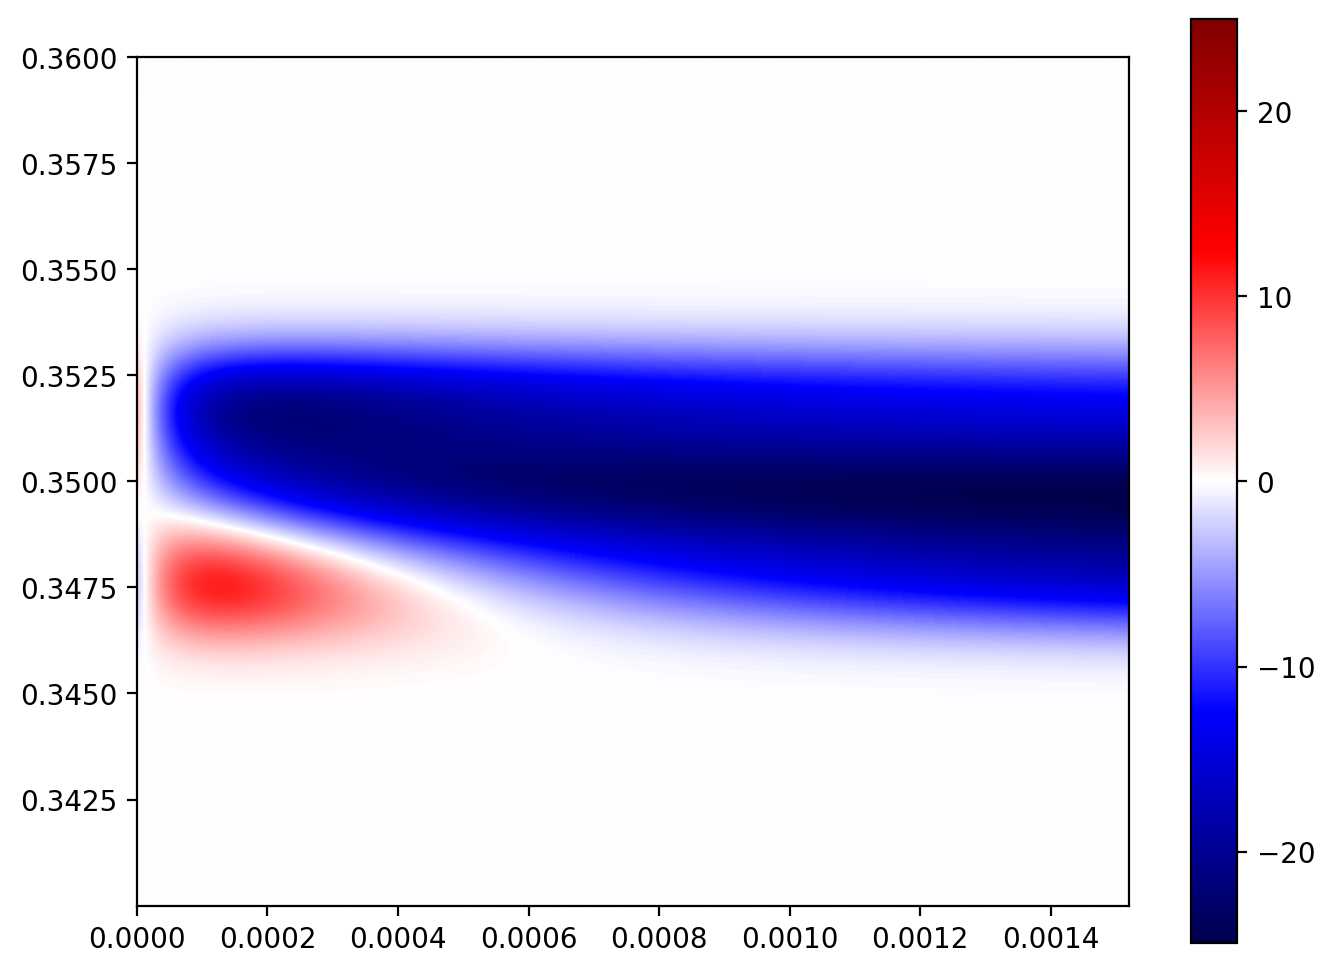

In [240]:
start_idx = 1
ans = spec[:, start_idx:]


plot_heat_map(fields_t1.numpy(), time[start_idx:].numpy(), (ans - ans[:, 1].unsqueeze(-1)).numpy())

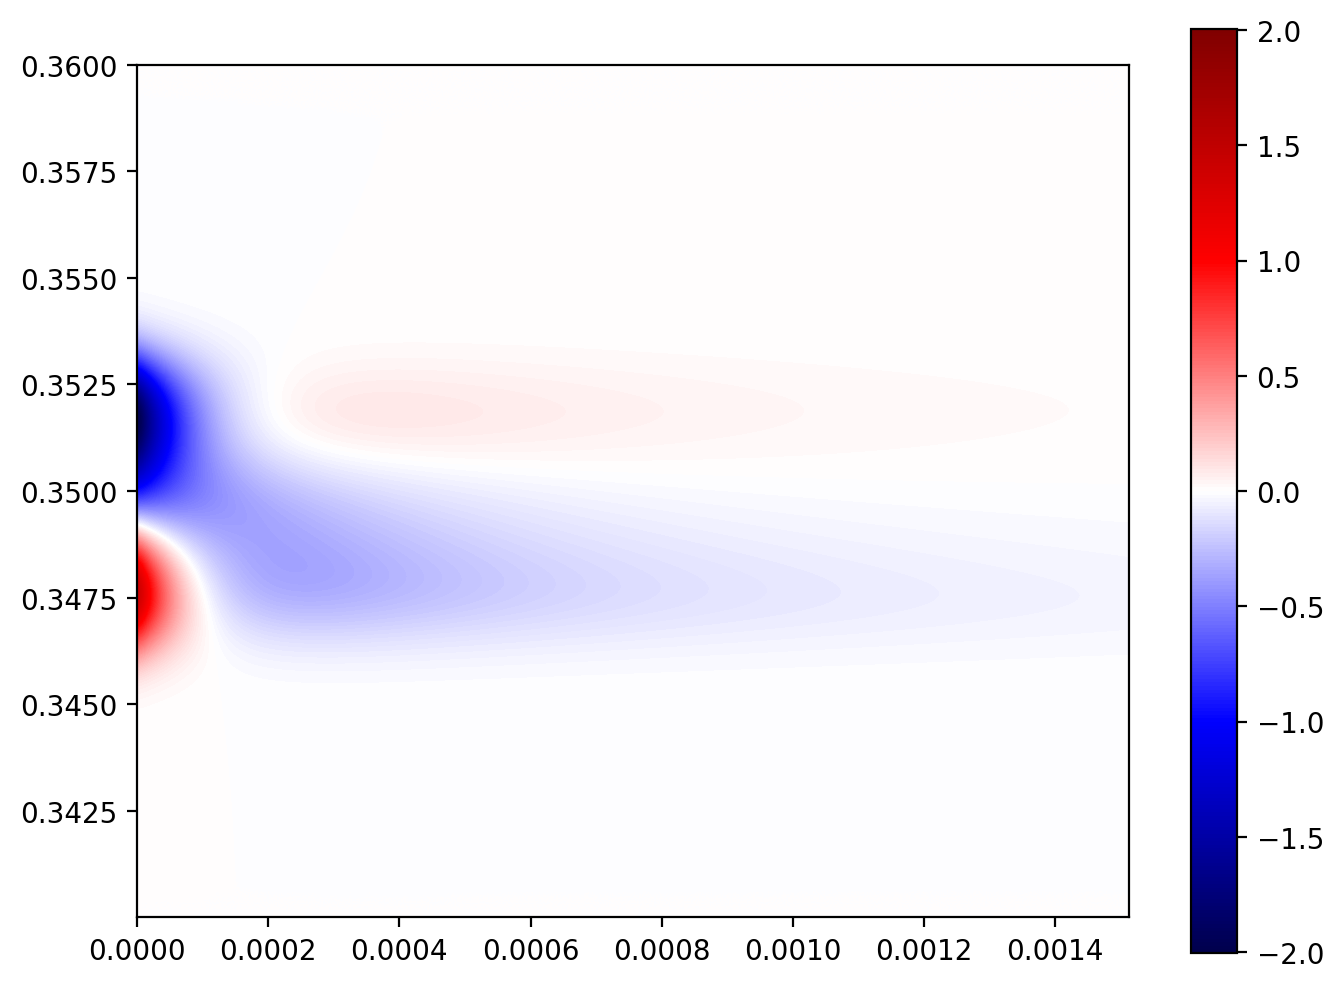

In [219]:
start_idx = 4
ans = spec[:, start_idx:]

plot_heat_map(fields_t1.numpy(), time.numpy()[:-1], (ans [:, 1:] - ans [:, :-1]).numpy())

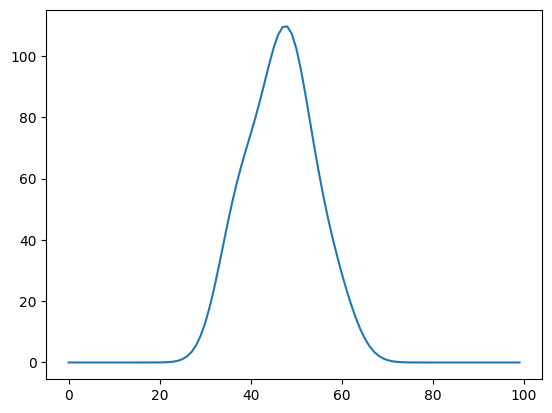

In [220]:
plt.plot(spec.numpy()[:, 67])

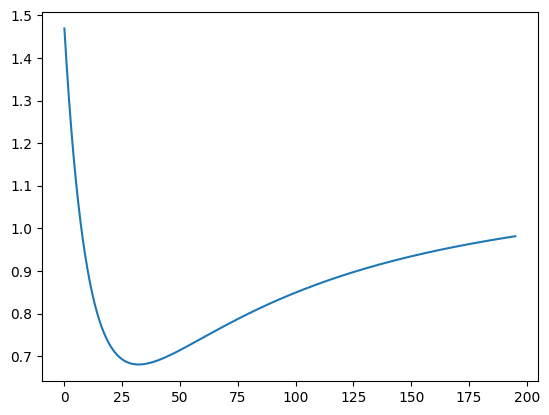

In [222]:
plt.plot(ans.numpy()[70, :])

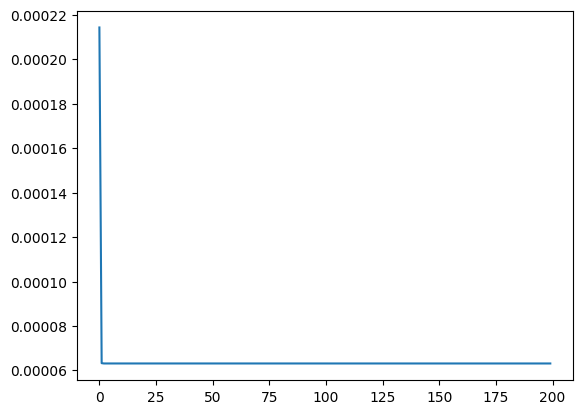

In [378]:
plt.plot(spec.numpy()[50, :])

In [111]:
F, Gx, Gy, Gz = powder.get_hamiltonian_terms()

In [142]:
import typing as tp
import qutip
import scipy

class AdvanceDensity(population.BaseTimeDependantPopulator):
    def __init__(self,
                 start_temp: float = 4.2,
                 context: dict[str, tp.Any] | None = None,):
        """
        :param start_temp: temperature in K
        """
        self.start_temp = torch.tensor(start_temp)
        self.context = context or None
        self.precision = "64"
        self.solver = EvolutionMatrixSolver.odeint_solver
        
    def _transofrm_to_eigenbasis(self, full_basis, args_vectors, args_matrix, **kwargs):
        out_vectors = []
        for vector in args_vectors:
            out_vectors.append(full_basis.conj().transpose(-1, -2) @ vector)
        
        out_matrix = []
        for matrix in args_matrix:
            out_matrix.append(full_basis.conj().transpose(-1, -2) @ matrix @ full_basis)
        return out_vectors, out_matrix
    
    def _vec(self, rho):
        shapes = rho.shape
        return rho.reshape(*shapes[:-2], shapes[-1] * shapes[-1])
    
    def _unvec(self, rho):
        shapes = rho.shape
        dim = int(math.sqrt(shapes[-1]))
        return rho.reshape(*shapes[:-1], dim, dim)
    
    def _get_initial_Hamiltonian(self, energies):
        return torch.diag_embed(energies)
        
    def _initial_density(self, energies, *args, **kwargs):
        populations = nn.functional.softmax(-constants.unit_converter(energies) / self.start_temp, dim=-1)
        density = torch.diag_embed(populations)
        
        if density.dtype == torch.float32:
            density = density.to(torch.complex64)
        elif density.dtype == torch.float64:
            density = density.to(torch.complex128)
        
        return density
    
    def propagator_2pi(self, config, evo, dtype, shape, n_steps=40):
        omega = config["freq"] * 2 * math.pi
        delta_phi = 2* math.pi / n_steps
        T = 2 * math.pi / omega
        times = torch.linspace(0, T, n_steps+1, dtype=torch.float64)
        d = shape[-1]**2
        initial_propagator = torch.eye(d, dtype=dtype).expand(*shape[:-2], d, d)
        
        U_times = self.solver(times, initial_propagator, evo)
        return U_times, times

    def U_N(self, U, power):
        return torch.matrix_power(U, power)
    
    def U_N_batched(self, U, powers):
        eiglev, eigbasis = torch.linalg.eig(U)
        embedings = torch.stack([torch.pow(eiglev, m) for m in powers], dim=-4)
        D = torch.diag_embed(embedings)
        
        return eigbasis @ D @ torch.linalg.inv(eigbasis)
        #return torch.stack([torch.matrix_power(U, m) for m in powers], dim=-5)
    
    def U_at(self, tau, U_list, ttensor):
        """Use property U(t) = U(phi1)*[U(2pi)]^N"""
        t_2pi = ttensor[-1]
        
        N = (tau / t_2pi).to(torch.int32)
        t1 = tau - N * t_2pi
        t1_idx = torch.searchsorted(ttensor, t1)

        if len(N) == 1:
            return self.U_N(U_list[-1], N)
        else:
            return self.U_N_batched(U_list[-1], N)

    def _get_resips(self, U_2pi, M_power):
        U_M = torch.linalg.matrix_power(U_2pi, M_power)            
        I = torch.eye(U_2pi.shape[-1], dtype=U_2pi.dtype, device=U_2pi.device)                                  
        resip_term_2pi = I - U_2pi
        resip_term_2pi_M = I - U_M
        return resip_term_2pi, resip_term_2pi_M
    
    def _get_integral_term(self, resip_term_2pi, resip_term_2pi_M, U_list, phi_interval):
        G = torch.linalg.solve(resip_term_2pi, resip_term_2pi_M)
        sum_part = U_list
        sum_term = torch.sum(
            sum_part[:-1] * torch.sin(phi_interval[:-1][:, None, None, None, None]), dim=-5)
        weighted_sum = sum_term @ G
        return weighted_sum
    
    
    def _compute_energy(
            self,
            config: dict,
            U_list: tp.List[torch.Tensor],
            tlist: torch.Tensor,
            rho_t: torch.Tensor,
            G: torch.Tensor,
        ) -> torch.Tensor:
            """Compute energy expectation value"""
            tau = 1 / config["freq"]
            w = config["freq"] * 2 * math.pi
            measurement_time = 80*1e-9
            M_power = int(measurement_time / tau)

            resip_term_2pi, resip_term_2pi_M = self._get_resips(U_list[-1], M_power)
            phi_interval = tlist * w
            delta_phi = phi_interval[1] - phi_interval[0]
            # Compute integral correction
            correction = (delta_phi / 12) * resip_term_2pi_M
            weighted_sum = self._get_integral_term(
                resip_term_2pi, 
                resip_term_2pi_M, 
                U_list, 
                phi_interval
            )
            #full_sum_term = weighted_sum + correction
            # Compute final expectation value
            integ_term = (delta_phi * (weighted_sum) @ rho_t / w).squeeze(dim=-1)
            
            
            integ_dm = self._unvec(integ_term)

            trace_term = G @ integ_dm
            trace_term = torch.diagonal(trace_term, dim1=-2, dim2=-1)
            
            a = -torch.diagonal(G @ integ_dm, dim1=-2, dim2=-1).sum(dim=-1).real
            print("-----------------------------")
            b = -torch.diagonal(G @ integ_dm, dim1=-2, dim2=-1).sum(dim=-1).imag
            return a
        

    def get_basis_and_energies(self, fields, F, Gz):
        energies, basis = torch.linalg.eigh(
            F.unsqueeze(0) + Gz.unsqueeze(0) * fields.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
        )
        return energies, basis
    
    def __call__(self, fields, F, Gx, Gy, Gz):
        energies, full_basis = self.get_basis_and_energies(fields, F, Gz)
        zero_vectors = config["zero_vectors"]

        coeffs = transform.get_transformation_coeffs(zero_vectors, full_basis)
        transformed_probs = transform.transform_rates_matrix(config["free_probs_tr"], coeffs)
        
        (zero_vectors, ), (Gx, Gy) =\
            self._transofrm_to_eigenbasis(full_basis, (zero_vectors,), (Gx, Gy))
        
        if self.precision == "64":
            zero_vectors = zero_vectors.to(torch.complex128)
            energies = energies.to(torch.float64)
            config["free_probs"] = config["free_probs"].to(torch.float64)
            Gx = Gx.to(torch.complex128)
            Gy = Gy.to(torch.complex128)
        else:
            pass
        
        H0 = self._get_initial_Hamiltonian(energies) * math.pi * 2
        
        evo_vector = tr_utils.EvolutionMatrix(energies)
        new_temp = 4.2
        transition_matrix = evo_vector(new_temp, transformed_probs + config["free_probs"])
        batch = transition_matrix.shape
        coherences = config["coherences"].expand(*batch)
        
        # FIND GX energy
        Ht = config["B1"] * Gx
        evo = EvolutionSuper(H0, Ht, transition_matrix, context=config, coher_matrix=coherences)
        
        dtype = Gx.dtype
        shape = H0.shape
        U_list, tlist = self.propagator_2pi(config, evo, dtype, shape, n_steps=200)
        U_N = self.U_at(time, U_list, tlist)
        #U_N = self.make_trace_preserving(U_N)
        
        rho_0 = self._vec(self._initial_density(energies))
        
        rho_t = U_N @ rho_0.unsqueeze(-1)
        
        rho_t[0] = rho_0.unsqueeze(-1)
        energy_x = self._compute_energy(config, U_list, tlist, rho_t, Gx)
        
        rho_t = self._unvec(rho_t.squeeze(dim=-1))
        populations_x = rho_t.diagonal(dim1=-1, dim2=-2).real
        
        # FIND Gy energy
        Ht = config["B1"] * Gy
        evo = EvolutionSuper(H0, Ht, transition_matrix, context=config, coher_matrix=coherences)

        
        dtype = Gx.dtype
        shape = H0.shape
        U_list, tlist = self.propagator_2pi(config, evo, dtype, shape, n_steps=200)
        U_N = self.U_at(time, U_list, tlist)
        #U_N = self.make_trace_preserving(U_N)
        
        
        rho_0 = self._vec(self._initial_density(energies))
        rho_t = U_N @ rho_0.unsqueeze(-1)   
        energy_y = self._compute_energy(config, U_list, tlist, rho_t, Gy)
        
        rho_t = self._unvec(rho_t.squeeze(dim=-1))
        populations_y = rho_t.diagonal(dim1=-1, dim2=-2).real
        
        pops = (populations_x + populations_y) / 2
        #out = self._post_compute(initial_populations, pops, lvl_down, lvl_up)
        out = energy_x + energy_y
        #out = out
        return out.mean(dim=-1)

In [143]:
advance_density = AdvanceDensity(4.2, config)

In [ ]:
with torch.no_grad():
    fields_t1 = torch.linspace(0.240, 0.460, 10)
    spec = advance_density(fields_t1, F, Gx, Gy, Gz)

In [ ]:
start_idx = 4
ans = spec[:, start_idx:]

plot_heat_map(fields_t1.numpy(), time.numpy(), spec.numpy())

In [ ]:
plot_heat_map(fields_t1.numpy(), time.numpy(), spec.numpy())

In [77]:
spec.shape

torch.Size([10])

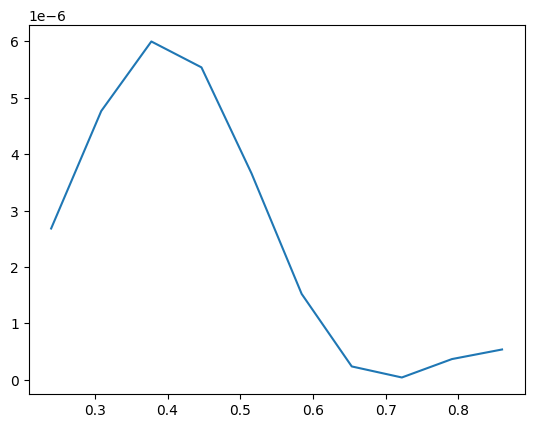

In [139]:
plt.plot(fields_t1.numpy(), spec.numpy())